In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sosfiltfilt, butter, lfilter, filtfilt, find_peaks,spectrogram
from scipy import interpolate
import pywt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

!pip install tslearn

from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.5/368.5 kB 2.9 MB/s eta 0:00:00


In [46]:
# load_data
sampling_rate = 100  # Hz
duration = 10

data = np.load('/content/drive/MyDrive/Data/simu_0.1_90_180R.npy')
data_clean = np.load('/content/drive/MyDrive/Data/simu_0_90_180R.npy')
data_clean_NoRR = np.load('/content/drive/MyDrive/Data/simu_0_90_180_NoRR.npy')


signals_labels, signals =  data[:, -6:], data[:, :1000]
signals_clean =  data_clean[:, :1000]
signals_clean_NoRR =  data_clean_NoRR[:, :1000]

signals_clean_NoRR.shape

(3000, 1000)

3000
0.001 --> 0.001 --> 
0.001 --> 0.001 --> 
0.009 --> 0.001 --> 0.001 --> 
0.020 --> 0.020 --> 0.020 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.017 --> 0.017 --> 0.017 --> 0.018 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 0.000 --> 
0.001 --> 0.001 --> 
0.045 --> 0.040 --> 0.040 --> 
0.000 --> 0.000 --> 
0.002 --> 0.002 --> 
0.001 --> 0.001 --> 0.001 --> 
0.003 --> 0.003 --> 0.003 --> 
0.002 --> 0.002 --> 0.002 --> 0.002 --> 
0.000 --> 0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 0.000 --> 
0.000 --> 0.000 --> 0.000 --> 
0.000 --> 0.000 --> 0.000 --> 
0.001 --> 0.001 --> 
0.000 --> 0.000 --> 0.000 --> 0.000 --> 
0.015 --> 0.014 --> 0.012 --> 0.012 --> 
0.000 --> 0.000 --> 
0.001 --> 0.001 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.000 --> 0.000 --> 
0.001 --> 0.001 --> 
0.001 --> 0.001 --> 
0.000 --> 0.000 --> 
0.001 --> 

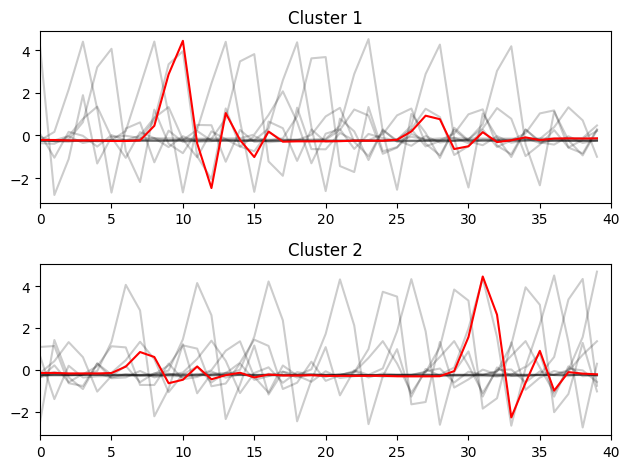

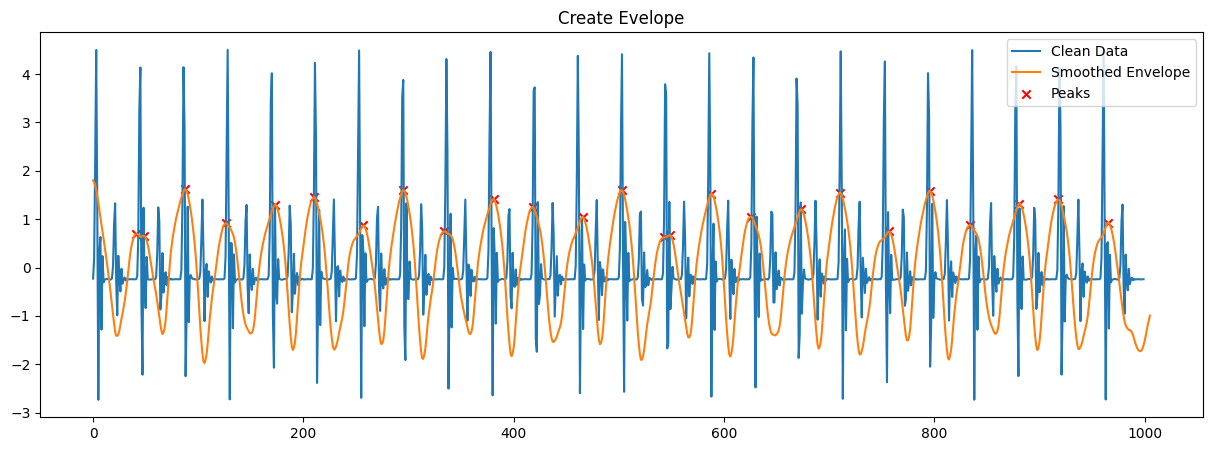

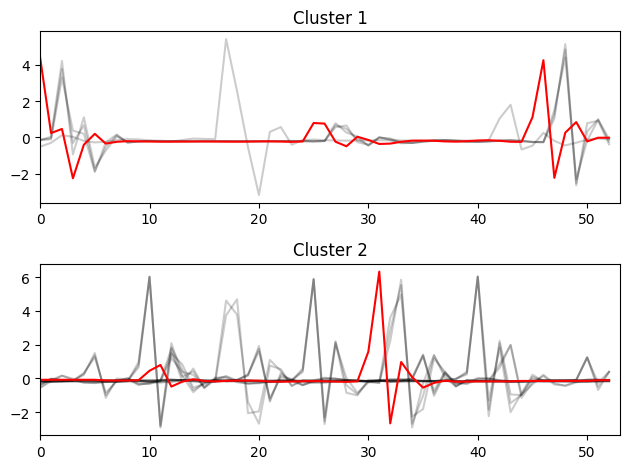

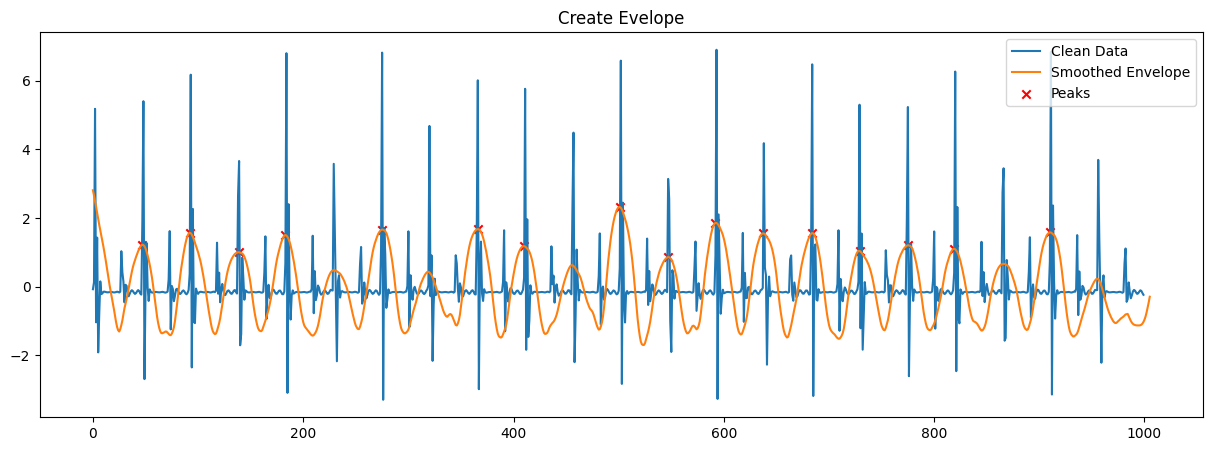

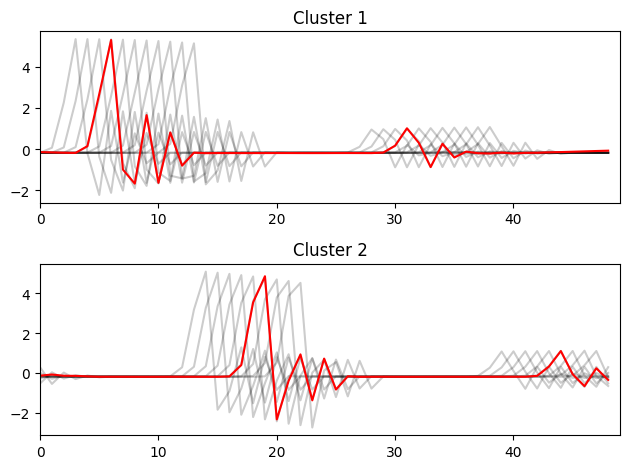

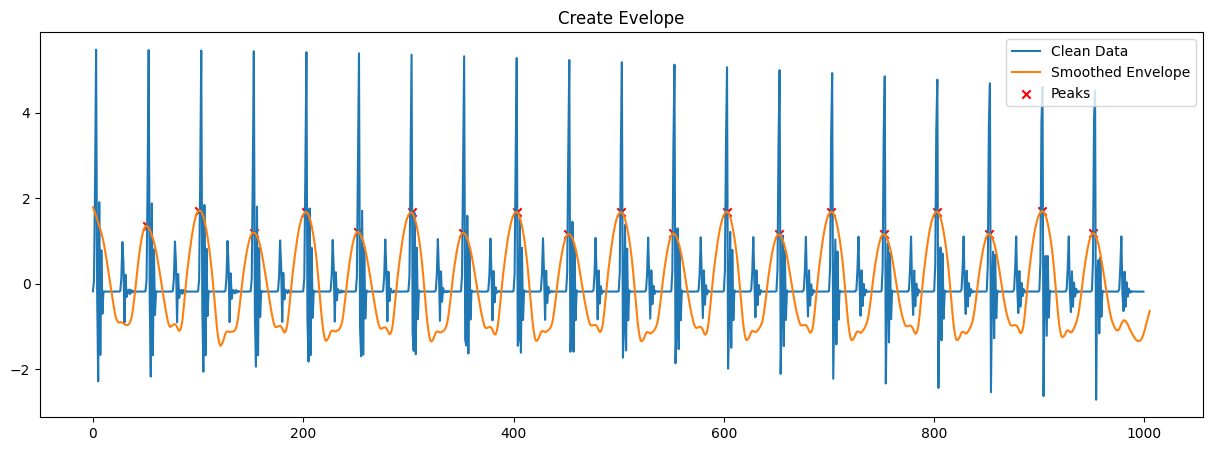

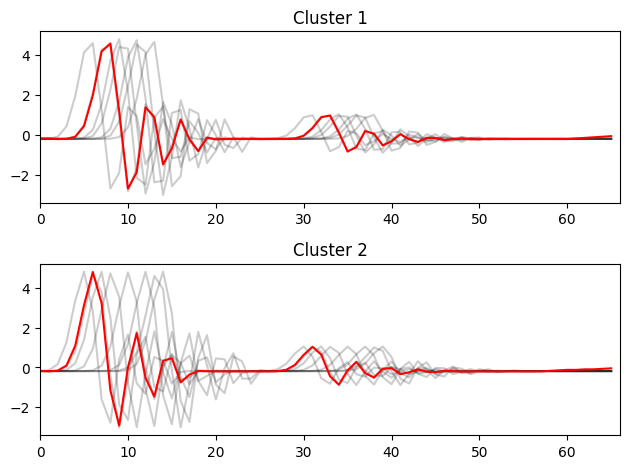

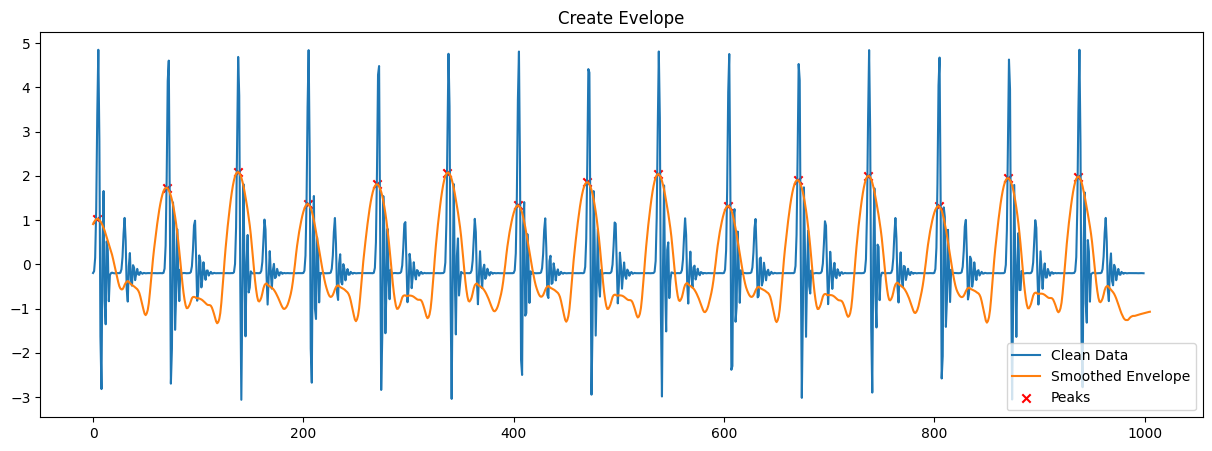

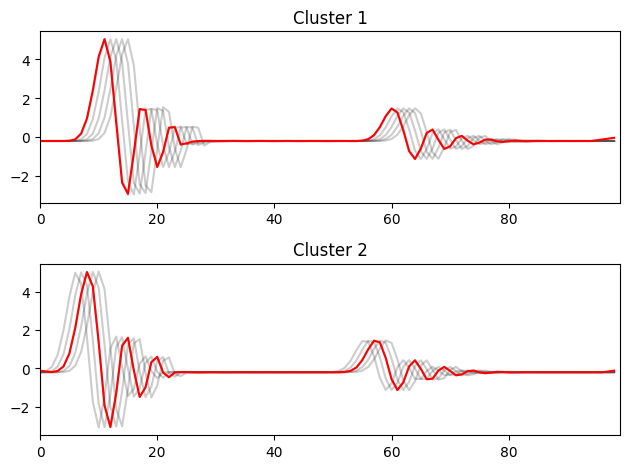

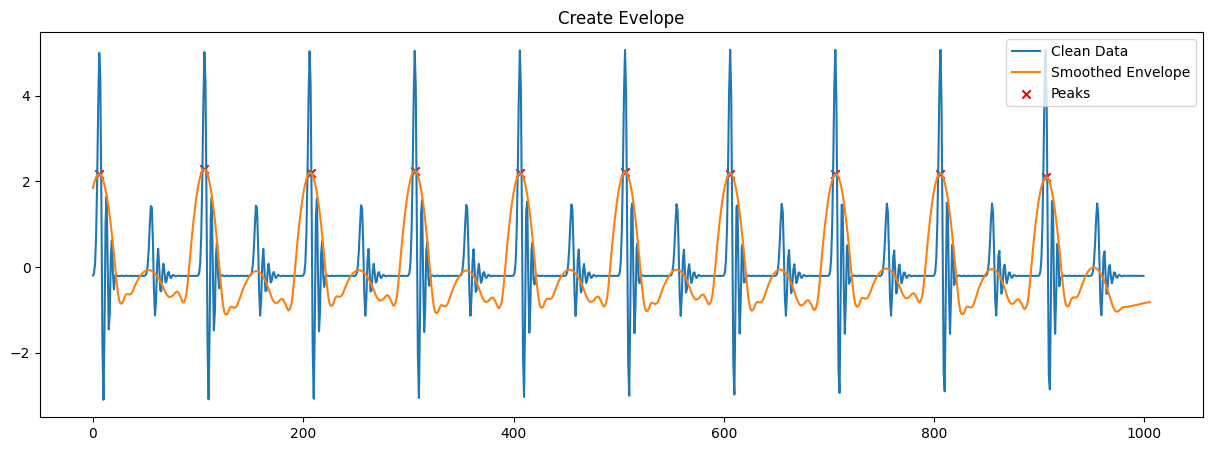

In [40]:
from scipy.signal import hilbert, savgol_filter

def standize(data):
    return (data - np.mean(data))/np.std(data)

def wavelet_decomposition(data, wave, Fs = None, n_decomposition = None):
    a = data
    w = wave
    ca = []
    cd = []
    rec_a = []
    rec_d = []
    freq_range = []
    for i in range(n_decomposition):
        if i == 0:
            freq_range.append(Fs/2)
        freq_range.append(Fs/2/(2** (i+1)))
        (a, d) = pywt.dwt(a, w)
        ca.append(a)
        cd.append(d)

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec = pywt.waverec(coeff_list, w)
        rec_a.append(rec)
        # ax3[i].plot(Fre, FFT_y1)
        # print(max_freq)

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    return rec_a, rec_d

def get_envelope(data, n_decomposition, Fs):
  # x = (x - np.mean(x))/np.std(x)
  x = standize(data)
  # x = data
  denoised_sig = wavelet_denoise(signal = x, Fs = Fs, n_decomposition = n_decomposition)
  z= hilbert(denoised_sig) #form the analytical signal
  envelope = np.abs(z)
  smoothed_envelope = savgol_filter(envelope, 41, 2, mode='nearest')
  smoothed_envelope = (smoothed_envelope - np.mean(smoothed_envelope))/np.std(smoothed_envelope)
  return smoothed_envelope


def wavelet_denoise(signal, Fs, n_decomposition):
  # x = (x - np.mean(x))/np.std(x)
  x = standize(signal)
  rec_a, rec_d = wavelet_decomposition(data = x, wave = 'db4', Fs = Fs, n_decomposition = n_decomposition)
  min_len = min(len(rec_d[-1]), len(rec_d[-2]), len(rec_d[-3]), len(rec_d[-4])) #len(rec_a[-1]) len(rec_d[-5])
  denoised_sig = rec_d[-1][:min_len] + rec_d[-2][:min_len] + rec_d[-4][:min_len] + rec_d[-3][:min_len] #+ rec_a[-1][:min_len]
  return denoised_sig


def ETSA_HR(peaks, fs= 100, up_bound = 0.9, low_bound = 0.1):
  distance = np.diff(peaks)

  #  up sort
  sorted_distance = np.sort(distance)
  # print(sorted_distance)
  Length = len(sorted_distance)
  up_pos, low_pos = int(Length * up_bound), int(Length * low_bound)

  sub_sorted_distance = sorted_distance[low_pos: up_pos]

  mean_distance = np.mean(sub_sorted_distance)

  return int(( 60 * fs ) / mean_distance), int(mean_distance)


# Segmentation
def Segmentation(signal, hr, threhold = 0.67):
  Length = len(signal)
  start, end = 0, hr

  pieces = []
  # pairs = []
  for i in range(Length):

    if end >= Length:
      continue
      if end - Length > hr * (1 - threhold):
        break
      else:
        end = 1000
    # pairs.append([start, end])
    seg = signal[start: end]
    pieces.append(seg)
    start, end = end, end + hr

  # print(len(pieces))
  return pieces


def K_shape(signal_pieces, num_clusters=2, show=False, seed=42):
  np.random.seed(seed)

  X_train = signal_pieces
  X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
  sz = X_train.shape[1]

  # kShape clustering
  ks = KShape(n_clusters=num_clusters, verbose=True, random_state=seed)
  y_pred = ks.fit_predict(X_train)

  if show:
    plt.figure()
    for yi in range(num_clusters):
        plt.subplot(num_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        # plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))
    plt.tight_layout()
    # plt.show()
    plt.savefig(fig_path+'NoNoise_K_shape_' + str(i) + '.jpg', dpi=300)


  # we need to make sure which one is best
  # print(y_pred, type(y_pred))
  if num_clusters == 2:
    all_N = len(y_pred)
    cluster_1 = np.sum(y_pred)
    if cluster_1 >= all_N - cluster_1:
      # print(type(ks.cluster_centers_[1].ravel()))
      # print(ks.cluster_centers_[1].ravel().shape)
      return ks.cluster_centers_[1].ravel()
    else:
      return ks.cluster_centers_[0].ravel()


show = False
N_ = len(signals_clean_NoRR)
print(N_)
N =  N_
all_pieces = []
all_templates = []

fig_path = '/content/drive/MyDrive/Pic/'
for i in range(N):
  if i % 701 == 21:
    show = True
  else:
    show = False

  data = signals_clean_NoRR[i,:]
  smoothed_envelope = get_envelope(data = data, n_decomposition = 6, Fs = 100)
  peaks, _ = find_peaks(smoothed_envelope, height=np.max(smoothed_envelope) * 0.25)
  etsa_hr, peaks_distance = ETSA_HR(peaks)
  pieces = Segmentation(data, peaks_distance)
  all_pieces.append(pieces)
  template = K_shape(pieces, show=show)
  all_templates.append(template)

  if show:
    plt.figure(figsize=(15,5))
    plt.plot(standize(data), label='Clean Data')
    plt.plot(smoothed_envelope, label='Smoothed Envelope')
    plt.scatter(peaks, smoothed_envelope[peaks], marker = 'x', color='r', label='Peaks')
    plt.title('Create Evelope')
    plt.legend()
    plt.savefig(fig_path+'NoNoise_evelope_'+str(i)+'.jpg', dpi=300)


In [42]:
from sklearn.cluster import KMeans

def K_means(signals, num_clusters ):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(signals)
    return cluster_labels

In [44]:
def K_shapes(signal_pieces, num_clusters, show=False, seed=43):
  np.random.seed(seed)

  X_train = signal_pieces
  X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
  sz = X_train.shape[1]

  # kShape clustering
  ks = KShape(n_clusters=num_clusters, verbose=True, random_state=seed)
  y_pred = ks.fit_predict(X_train)

  if show:
    plt.figure()
    for yi in range(num_clusters):
        plt.subplot(num_clusters, 1, 1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        # plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))
    plt.tight_layout()
    plt.show()

  return y_pred



In [53]:
mmax, mmin = 0, 999

for template in all_templates:
  if len(template) > mmax:
    mmax = len(template)
  if len(template) < mmin:
    mmin = len(template)
  # print(template.shape)
print(mmax, mmin)

new_all_templates = []
for template in all_templates:
  new_template = np.pad(template, [0, mmax - len(template)], 'constant')
  new_all_templates.append(new_template)
  # print(new_template.shape)

138 31


0.065 --> 0.063 --> 0.061 --> 0.059 --> 0.056 --> 0.056 --> 0.063 --> 


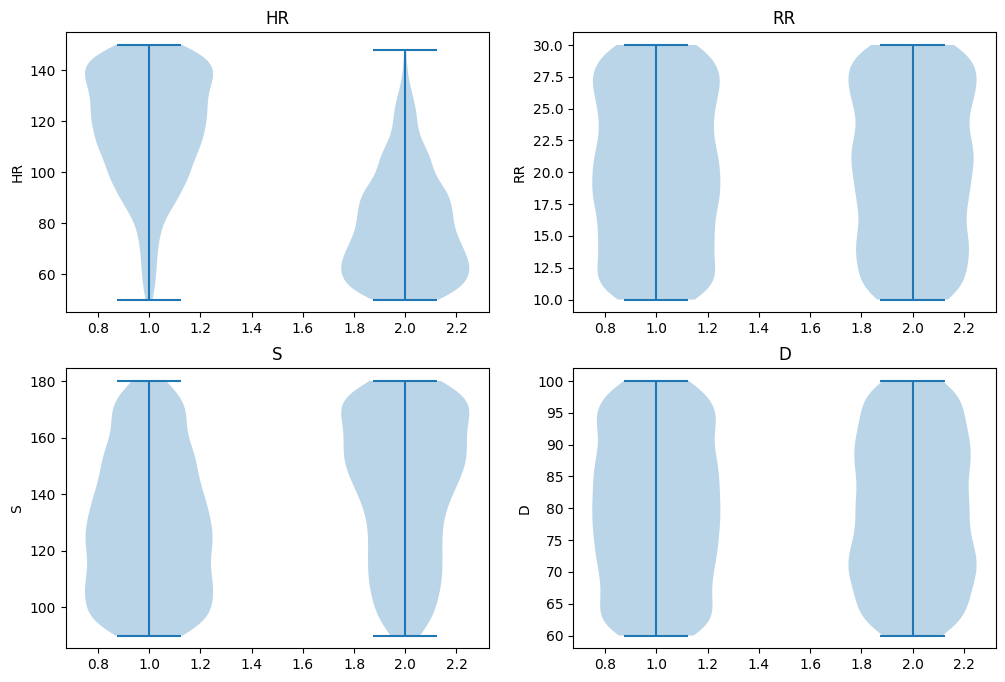

In [68]:

num_clusters = 2

K_shape_labels = K_shapes(new_all_templates, num_clusters)
Methods_labels = K_shape_labels

# K_Means_labels = K_means(new_all_templates, num_clusters)
# Methods_labels = K_Means_labels

all_clustered_HR = []
all_clustered_RR = []
all_clustered_S = []
all_clustered_D = []


for i in range(num_clusters):
  # print(i)
  # clustered_data = signals_clean_[Methods_labels == i]
  clustered_labels = signals_labels[Methods_labels == i]
  all_clustered_HR.append(clustered_labels[:, 2])
  all_clustered_RR.append(clustered_labels[:, 3])
  all_clustered_S.append(clustered_labels[:, 4])
  all_clustered_D.append(clustered_labels[:, 5])
  # print(clustered_data.shape, clustered_labels.shape)


fig, axes = plt.subplots( 2, 2, figsize=(12, 8) )

axes[0, 0].set_title('HR')
axes[0, 0].set_ylabel('HR')
axes[0, 0].violinplot(all_clustered_HR)

axes[0, 1].set_title('RR')
axes[0, 1].set_ylabel('RR')
axes[0, 1].violinplot(all_clustered_RR)

axes[1, 0].set_title('S')
axes[1, 0].set_ylabel('S')
axes[1, 0].violinplot(all_clustered_S)

axes[1, 1].set_title('D')
axes[1, 1].set_ylabel('D')
axes[1, 1].violinplot(all_clustered_D)

# plt.show()
plt.savefig('\content\drive\MyDrive\Template_Kshapes_2.jpg', dpi=300)

In [55]:
from scipy.stats import kurtosis, skew, scoreatpercentile
def statistics_features(signal):
    features = {}

    features['Maximum'] = np.max(signal)
    features['Minimum'] = np.min(signal)
    features['Mean'] = np.mean(signal)
    features['Median'] = np.median(signal)
    features['Variance'] = np.var(signal)
    features['Kurtosis'] = kurtosis(signal)
    features['Skewness'] = skew(signal)
    features['0.75Percentile'] = scoreatpercentile(signal, 75)
    features['0.25Percentile'] = scoreatpercentile(signal, 25)

    return features

# signal = template
# features = statistics_features(signal)
# print(features)

In [ ]:
from scipy.stats import entropy

def calculate_rms(signal):
    rms = np.sqrt(np.mean(np.square(signal)))
    return rms

def calculate_zero_crossing_rate(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zcr_rate = len(zero_crossings) / (len(signal) - 1)
    return zcr_rate


def calculate_entropy(signal):
    prob_distribution = np.histogram(signal, bins=10, density=True)[0]
    ent = entropy(prob_distribution)
    return ent


def calculate_centroid(signal):
    centroid = np.sum(np.arange(len(signal)) * np.abs(signal)) / np.sum(np.abs(signal))
    return centroid

def calculate_mean_absolute_differences(signal):
    mad = np.mean(np.abs(np.diff(signal)))
    return mad

def calculate_mean_differences(signal):
    mean_diff = np.mean(np.diff(signal))
    return mean_diff

def calculate_median_absolute_differences(signal):
    med_abs_diff = np.median(np.abs(np.diff(signal)))
    return med_abs_diff

def calculate_median_differences(signal):
    med_diff = np.median(np.diff(signal))
    return med_diff

def calculate_sum_of_absolute_differences(signal):
    sad = np.sum(np.abs(np.diff(signal)))
    return sad

def calculate_absolute_energy(signal):
    abs_energy = np.sum(np.square(signal))
    return abs_energy

def calculate_total_energy(signal):
    total_energy = np.sum(np.square(signal)) / len(signal)
    return total_energy


In [ ]:
from scipy.signal import welch
from scipy.stats import entropy

def calculate_spectral_entropy(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    prob_distribution = Pxx / np.sum(Pxx)
    spec_entropy = entropy(prob_distribution)
    return spec_entropy

# Example usage
signal = np.random.randn(1000)  # Replace with your signal
fs = 1000  # Replace with your sampling rate
spectral_entropy = calculate_spectral_entropy(signal, fs)
print("Spectral Entropy:", spectral_entropy)

def calculate_spectral_centroid(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)
    return spectral_centroid

# Example usage
spectral_centroid = calculate_spectral_centroid(signal, fs)
print("Spectral Centroid:", spectral_centroid)


import numpy as np
from scipy.signal import welch, find_peaks
from scipy.stats import kurtosis, skew

# Calculate Spectral Maximum Peaks
def calculate_spectral_max_peaks(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    peaks, _ = find_peaks(Pxx)
    max_peaks = f[peaks]
    return max_peaks

# Calculate Spectral Roll-off
def calculate_spectral_roll_off(signal, fs, roll_off_percent=0.85):
    f, Pxx = welch(signal, fs=fs)
    cumsum_pxx = np.cumsum(Pxx)
    total_power = cumsum_pxx[-1]
    roll_off_idx = np.argmax(cumsum_pxx >= roll_off_percent * total_power)
    roll_off_freq = f[roll_off_idx]
    return roll_off_freq

# Calculate Median Frequency (MDF)
def calculate_median_frequency(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    cumsum_pxx = np.cumsum(Pxx)
    median_power = cumsum_pxx[-1] / 2
    mdf_idx = np.argmax(cumsum_pxx >= median_power)
    mdf_freq = f[mdf_idx]
    return mdf_freq

# Calculate Max Frequency
def calculate_max_frequency(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    max_freq = f[np.argmax(Pxx)]
    return max_freq

# Calculate Peak Frequency
def calculate_peak_frequency(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    peaks, _ = find_peaks(Pxx)
    peak_freq = f[peaks[np.argmax(Pxx[peaks])]]
    return peak_freq

# Calculate Kurtosis
def calculate_kurtosis(signal):
    kurt = kurtosis(signal)
    return kurt

# Calculate Skewness
def calculate_skewness(signal):
    skewness = skew(signal)
    return skewness

# Example usage
signal = np.random.randn(1000)  # Replace with your signal
fs = 1000  # Sampling frequency

print("Spectral Maximum Peaks:", calculate_spectral_max_peaks(signal, fs))
print("Spectral Roll-off:", calculate_spectral_roll_off(signal, fs))
print("Median Frequency (MDF):", calculate_median_frequency(signal, fs))
print("Max Frequency:", calculate_max_frequency(signal, fs))
print("Peak Frequency:", calculate_peak_frequency(signal, fs))
print("Kurtosis:", calculate_kurtosis(signal))
print("Skewness:", calculate_skewness(signal))


from scipy.signal import spectrogram

!pip install python_speech_features
import python_speech_features as psf

# Calculate Power Bandwidth
def calculate_power_bandwidth(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    total_power = np.sum(Pxx)
    power_bandwidth = np.sum(Pxx >= total_power / 2)
    return power_bandwidth

# Calculate Maximum Power Spectrum
def calculate_max_power_spectrum(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    max_power_spectrum = np.max(Pxx)
    return max_power_spectrum

# # Calculate Human Range Energy
# def calculate_human_range_energy(signal, fs):
#     _, _, Sxx = spectrogram(signal, fs=fs)
#     human_range_frequencies = (20, 20000)
#     human_range_energy = np.sum(Sxx[(frequencies >= human_range_frequencies[0]) & (frequencies <= human_range_frequencies[1])])
#     return human_range_energy

# Calculate Variation
def calculate_variation(signal):
    variation = np.std(signal) / np.mean(signal)
    return variation

# Calculate MFCC
def calculate_mfcc(signal, fs):
    mfcc = psf.mfcc(signal, samplerate=fs)
    return mfcc

# # Calculate LPCC
# def calculate_lpcc(signal, fs):
#     lpcc = psf.(signal, fs=fs)
#     return lpcc

# Example usage
signal = np.random.randn(1000)  # Replace with your signal
fs = 1000  # Sampling frequency

print("Power Bandwidth:", calculate_power_bandwidth(signal, fs))
print("Maximum Power Spectrum:", calculate_max_power_spectrum(signal, fs))
# print("Human Range Energy:", calculate_human_range_energy(signal, fs))
print("Variation:", calculate_variation(signal))
print("MFCC:", calculate_mfcc(signal, fs))
# print("LPCC:", calculate_lpcc(signal, fs))



SyntaxError: ignored

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from numpy import array
from scipy import stats


In [ ]:

def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
        if mph is not None:
            mph = -mph
    # find indices of all peaks
    dx = x[1:] - x[:-1]

    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))

    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]

    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]

    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]

    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])

    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
            if mph is not None:
                mph = -mph
        plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

def plot_peaks(x, mph, mpd, threshold, edge, valley, ax, ind):
        """Plot results of the detect_peaks function, see its help."""
#    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        plt.grid()
        plt.show()


58 6.833541953745153e-10


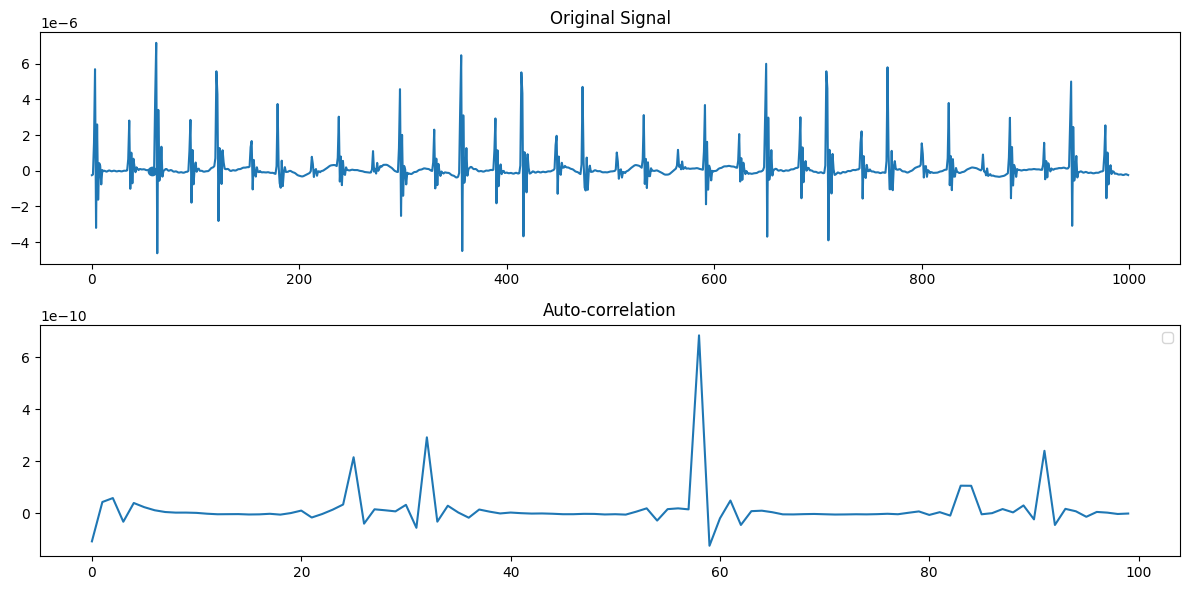

In [ ]:
signal_length = 1000
signal = signals[0,:]
max_lag = 100
auto_correlation = np.correlate(signal, signal, mode='full')
auto_correlation = auto_correlation[1000:1000+max_lag]


max_auto_corr_index = np.argmax(auto_correlation)
max_auto_corr_value = auto_correlation[max_auto_corr_index]
print(max_auto_corr_index, max_auto_corr_value)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.scatter(max_auto_corr_index, max_auto_corr_value)
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(np.arange(0, 100), auto_correlation[:100])
plt.title('Auto-correlation')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def fft_denoise(signal, fs, threshold):
  n = len(signal) #1000
  dt = fs
  fhat = np.fft.fft(signal, n)
  psd = fhat * np.conjugate(fhat)/n
  freq = (1/(dt*n)) * np.arange(n)
  L = np.arange(1, np.floor(n/2), dtype = 'int')
  indices = psd > threshold
  pdsclean = psd * indices
  fhat= indices * fhat
  ffilt = np.fft.ifft(fhat)
  ffilt = ffilt.real
  return ffilt

In [69]:
def plot_signal_and_spectrogram(data, title, fs, fmin, fmax, npseg):
  x = data
  f, t, Sxx = spectrogram(x, fs)
  print(x.shape, t.shape, Sxx.shape)
  print(t)
  plt.figure(figsize=(12,5))
  plt.title(title)

  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.plot(x)
  plt.title(title)
  plt.ylabel('Magnitude')
  plt.xlabel('Time [sec]')

  plt.subplot(1, 2, 2) # index 2
  print(int(fmin*npseg/fs), int(fmax*npseg/fs)+1)
  # print(np.abs(
  #     Sxx[
  #         int(fmin*npseg/fs):int(fmax*npseg/fs)+1,:
  #         ]
  #     ))
  plt.pcolormesh(t
                 , f[int(fmin*npseg/fs):int(fmax*npseg/fs)+1]
                 , np.abs(Sxx[int(fmin*npseg/fs):int(fmax*npseg/fs)+1,:])
  , shading='gouraud')
  plt.title("Spectrogram")
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')

  plt.show()

# plot_signal_and_spectrogram(signals[0], '', 100, 0, 50, 256 )
# # plot_signal_and_spectrogram(fft_denoise(signals[0], 100, 10), '', 100, 0, 50, 256 )

In [ ]:
def wavelet_decomposition(data, wave, Fs = None, n_decomposition = None):
    a = data
    w = wave
    ca = []
    cd = []
    rec_a = []
    rec_d = []
    freq_range = []
    for i in range(n_decomposition):
        if i == 0:
            freq_range.append(Fs/2)
        freq_range.append(Fs/2/(2** (i+1)))
        (a, d) = pywt.dwt(a, w)
        ca.append(a)
        cd.append(d)

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec = pywt.waverec(coeff_list, w)
        rec_a.append(rec)
        # ax3[i].plot(Fre, FFT_y1)
        # print(max_freq)

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    return rec_a, rec_d


def wavelet_denoise(signal, Fs, n_decomposition):
    # x = (x - np.mean(x))/np.std(x)
    x = standize(signal)
    rec_a, rec_d = wavelet_decomposition(data = x, wave = 'db4', Fs = Fs, n_decomposition = n_decomposition)

    min_len = min(len(rec_d[-1]), len(rec_d[-2]), len(rec_d[-3]), len(rec_d[-4])) #len(rec_a[-1]) len(rec_d[-5])
    denoised_sig = rec_d[-1][:min_len] + rec_d[-2][:min_len] + rec_d[-4][:min_len] + rec_d[-3][:min_len] #+ rec_a[-1][:min_len]
    return denoised_sig

def wdenoise(data, method, threshold):
    # Create wavelet object and define parameters
    w = pywt.Wavelet(method)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, method, level=maxlev)
    #cA = 0.0
    #cA = pywt.threshold(cA, threshold*max(cA))
    # plt.figure()
    for i in range(1, len(coeffs)):
        # plt.subplot(maxlev, 1, i)
        # plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        # plt.plot(coeffs[i])
    datarec = pywt.waverec(coeffs, method)
    return datarec

maximum level is 7
(1000,) (4,) (129, 4)
[1.28 3.52 5.76 8.  ]
0 129


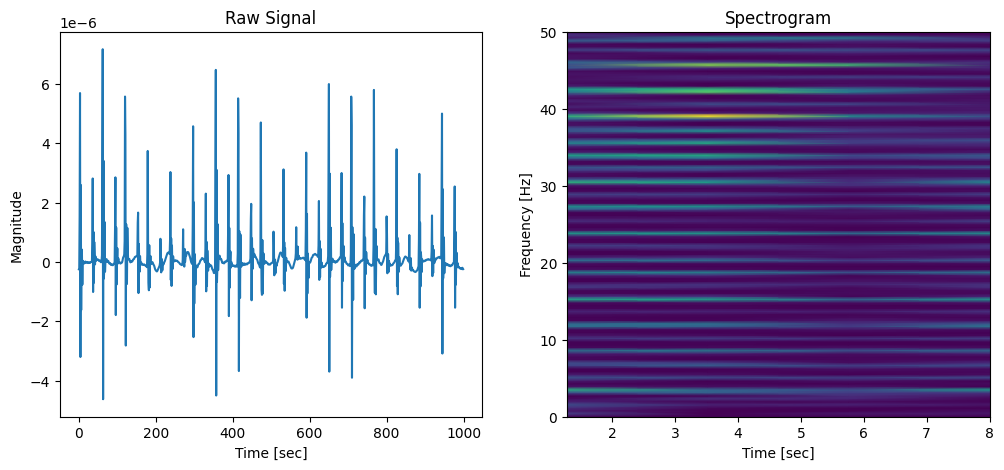

(1000,) (4,) (129, 4)
[1.28 3.52 5.76 8.  ]
0 129


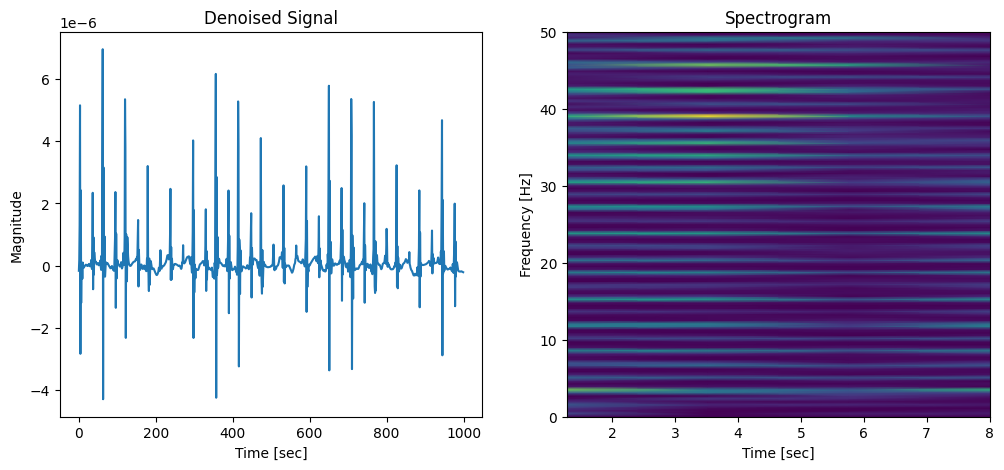

In [ ]:
data = signals[0]
denoise = wdenoise(data, 'sym4', 0.05)

fs = sampling_rate
fmin = 0
fmax = 10
npseg = 256 #256

title = "Raw Signal"
plot_signal_and_spectrogram(data, title, fs, fmin, 50, npseg)

data = denoise
title = "Denoised Signal"
plot_signal_and_spectrogram(data, title, fs, fmin, 50, npseg)